# Emmbeddaus

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery df --project touhua-001
select distinct ecom_categoryPath
# select distinct ecom_category as ecom_categoryPath
FROM
touhua-001.dm_kesko.d_product

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df

,ecom_categoryPath
0,liha-ja-kasviproteiinit/porsas/fileet-kyljykse...
1,kuivat-elintarvikkeet-ja-leivonta/pastat/lasagnet
2,lemmikit/muut-lemmikkienhoitotarvikkeet/linnun...
3,makeiset-ja-naposteltavat/sipsit-ja-snacksit/s...
4,juomat/lonkerot/greippilonkerot
...,...
979,kirjat-lehdet-ja-paperitarvikkeet/lehdet/iltap...
980,kirjat-lehdet-ja-paperitarvikkeet/lehdet/aamul...
981,sailykkeet-keitot-ja-ateria-ainekset/kuivaruok...
982,kirjat-lehdet-ja-paperitarvikkeet/lehdet/yleis...


In [ ]:
!pip install openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.1/375.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00


Luodaan embeddaukset tuoteryhmille...


<ipython-input-7-cfa7609296b1>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embedding'] = df['ecom_categoryPath'].apply(lambda x: get_embedding(x, model='text-embedding-3-small'))


Embeddaukset luotu.
Valmistellaan visualisointia...


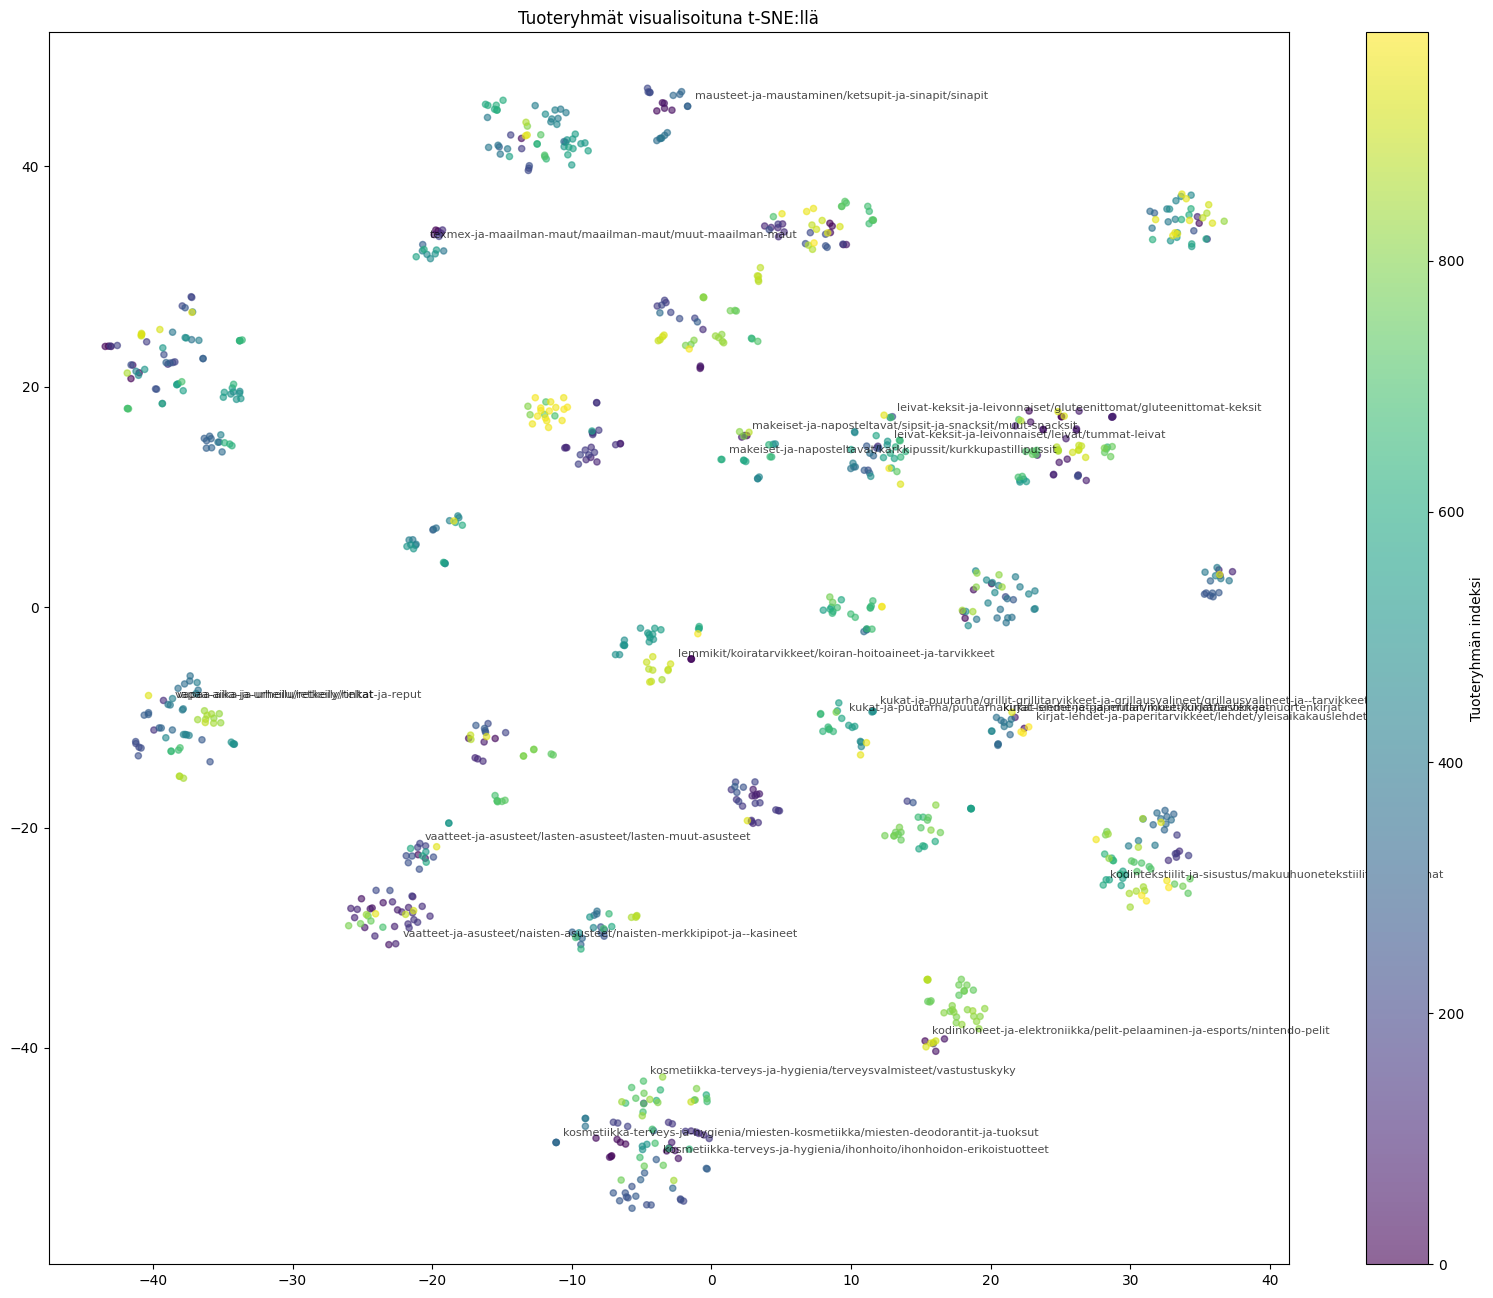

Visualisointi valmis.



Yhteenveto:
Tuoteryhmiä yhteensä: 983

Esimerkkejä tuoteryhmistä:
kukat-ja-puutarha/kukkaruukut-ja-kukkalaatikot/...
sahko-pienrauta-ja-autotarvikkeet/tyokalut-ja-p...
vaatteet-ja-asusteet/naisten-vaatteet/naisten-t...
kala-ja-merenelavat/ravut-simpukat-ja-ayriaiset...
kodinkoneet-ja-elektroniikka/tietokoneet-ja-tie...
                     juomat/siiderit/omenasiiderit
kirjat-lehdet-ja-paperitarvikkeet/lehdet/yleisa...
            pakasteet/pizzat-ja-pizzapohjat/pizzat
                   pakasteet/jaatelot/jaatelokakut
kodintekstiilit-ja-sisustus/makuuhuonetekstiili...

Esimerkkejä tuoteryhmähierarkiasta:

liha-ja-kasviproteiinit
  - porsas
    - fileet-kyljykset-ja-pihvit: 1
    - suikaleet-ja-kuutiot: 1
  - lammas-poro-ja-riista
    - lammas: 1
    - poro: 1
  - broileri-kana-ja-kalkkuna
    - fileet-pihvit-ja-rullat: 1
    - kokonainen-broileri-ja-kalkkuna: 1

kuivat-elintarvikkeet-ja-leivonta
  - pastat
    - lasagnet: 1
    - pastat: 1
  - murot-ja-myslit
    - murot: 1
    - glu

In [ ]:
import pandas as pd
import numpy as np
from openai import OpenAI
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict

client = OpenAI(api_key="")


def get_embedding(text, model="text-embedding-3-small"):
    if pd.isna(text):
        return None
    text = str(text).replace("\n", " ")
    response = client.embeddings.create(input=[text], model=model)
    return response.data[0].embedding


df = df.dropna(subset=['ecom_categoryPath'])


if 'embedding' not in df.columns:
    print("Luodaan embeddaukset tuoteryhmille...")
    df['embedding'] = df['ecom_categoryPath'].apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
    print("Embeddaukset luotu.")


df = df.dropna(subset=['embedding'])

def visualisoi_tuoteryhmat(df):
    print("Valmistellaan visualisointia...")
    embeddings = np.array(df['embedding'].tolist())

    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='random', learning_rate=200)
    vis_dims = tsne.fit_transform(embeddings)

    plt.figure(figsize=(20, 16))
    scatter = plt.scatter(vis_dims[:, 0], vis_dims[:, 1], c=range(len(df)), cmap='viridis', alpha=0.6, s=20)

    n_annotations = min(20, len(df))
    random_indices = np.random.choice(len(df), n_annotations, replace=False)

    for idx in random_indices:
        plt.annotate(df['ecom_categoryPath'].iloc[idx],
                     (vis_dims[idx, 0], vis_dims[idx, 1]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    plt.title("Tuoteryhmät visualisoituna t-SNE:llä")
    plt.colorbar(scatter, label='Tuoteryhmän indeksi')
    plt.show()
    print("Visualisointi valmis.")

def luo_tuoteryhma_hierarkia(df):
    hierarkia = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for kategoria in df['ecom_categoryPath']:
        osat = kategoria.split('/')
        if len(osat) >= 1:
            hierarkia[osat[0]][osat[1] if len(osat) > 1 else ''][osat[2] if len(osat) > 2 else ''] += 1
    return hierarkia

def visualisoi_tuoteryhma_hierarkia(hierarkia):
    labels = []
    parents = []
    values = []

    for paa, alakategoriat in hierarkia.items():
        labels.append(paa)
        parents.append("")
        values.append(sum(sum(alakategoria.values()) for alakategoria in alakategoriat.values()))

        for ala, alinkat in alakategoriat.items():
            if ala:
                labels.append(f"{paa}/{ala}")
                parents.append(paa)
                values.append(sum(alinkat.values()))

                for alin, maara in alinkat.items():
                    if alin:
                        labels.append(f"{paa}/{ala}/{alin}")
                        parents.append(f"{paa}/{ala}")
                        values.append(maara)

    fig = go.Figure(go.Sunburst(
        labels=labels,
        parents=parents,
        values=values,
    ))
    fig.update_layout(title_text="Tuoteryhmien hierarkia")
    fig.show()


visualisoi_tuoteryhmat(df)

hierarkia = luo_tuoteryhma_hierarkia(df)
visualisoi_tuoteryhma_hierarkia(hierarkia)


print(f"\nYhteenveto:")
print(f"Tuoteryhmiä yhteensä: {len(df)}")
print("\nEsimerkkejä tuoteryhmistä:")
print(df['ecom_categoryPath'].sample(n=min(10, len(df))).to_string(index=False))


print("\nEsimerkkejä tuoteryhmähierarkiasta:")
for paa, alakategoriat in list(hierarkia.items())[:5]:  # Näytä 5 ensimmäistä pääkategoriaa
    print(f"\n{paa}")
    for ala, alinkat in list(alakategoriat.items())[:3]:  # Näytä 3 ensimmäistä alakategoriaa
        if ala:
            print(f"  - {ala}")
            for alin, maara in list(alinkat.items())[:2]:  # Näytä 2 ensimmäistä alikategoriaa
                if alin:
                    print(f"    - {alin}: {maara}")

Tuote 'Hubba Bubba Outrageous Original purukumi taskupakkaus Purukumipakkaukset' kuuluu todennäköisimmin seuraaviin ryhmiin:
pakasteet/jaatelot/monipakkaukset: 0.4532
juomat/oluet/oluiden-monipakkaukset: 0.4338
pakasteet/pizzat-ja-pizzapohjat/monipakkaukset: 0.4324
pakasteet/muut-pakasteet/ruokapakasteet: 0.4308
mausteet-ja-maustaminen/mausteet/suurpakkaukset: 0.4294


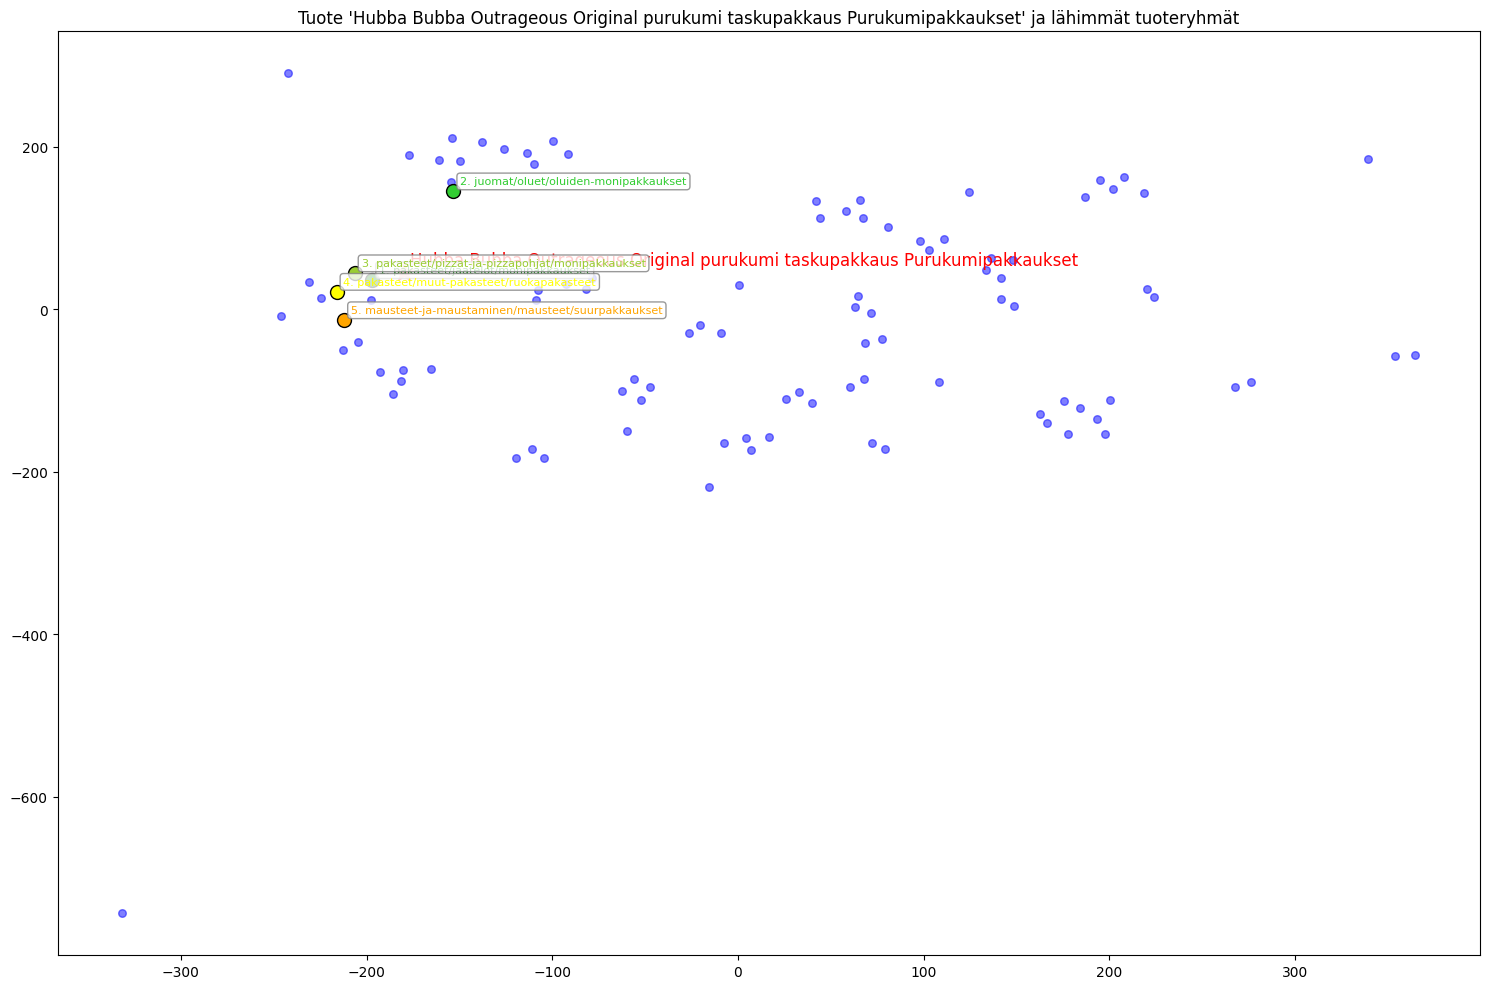

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

def luokittele_ja_visualisoi_tuote(tuotenimi, df, client):
    tuote_embedding = get_embedding(tuotenimi, model="text-embedding-3-small")

    df['similarities'] = df['embedding'].apply(lambda x: np.dot(x, tuote_embedding) / (np.linalg.norm(x) * np.linalg.norm(tuote_embedding)))

    top_5_indices = df['similarities'].nlargest(5).index
    top_5_tuoteryhmat = df.loc[top_5_indices]

    print(f"Tuote '{tuotenimi}' kuuluu todennäköisimmin seuraaviin ryhmiin:")
    for idx in top_5_indices:
        print(f"{df.loc[idx, 'ecom_categoryPath']}: {df.loc[idx, 'similarities']:.4f}")


    other_indices = df.index.difference(top_5_indices)
    sample_indices = np.random.choice(other_indices, size=min(95, len(other_indices)), replace=False)
    sample_df = df.loc[np.concatenate([sample_indices, top_5_indices])]

    sample_embeddings = np.array([emb for emb in sample_df['embedding'].values] + [tuote_embedding])


    tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='random', learning_rate=200)
    vis_dims = tsne.fit_transform(sample_embeddings)


    plt.figure(figsize=(15, 10))
    plt.scatter(vis_dims[:-1, 0], vis_dims[:-1, 1], c='blue', alpha=0.5, s=30)
    plt.scatter(vis_dims[-1, 0], vis_dims[-1, 1], c='red', s=200, marker='*')


    plt.annotate(tuotenimi, (vis_dims[-1, 0], vis_dims[-1, 1]), xytext=(5, 5),
                 textcoords='offset points', fontsize=12, color='red')


    colors = ['green', 'limegreen', 'yellowgreen', 'yellow', 'orange']
    for i, idx in enumerate(top_5_indices):
        sample_idx = np.where(sample_df.index == idx)[0][0]
        plt.scatter(vis_dims[sample_idx, 0], vis_dims[sample_idx, 1], c=colors[i], s=100, edgecolors='black')
        plt.annotate(f"{i+1}. {df.loc[idx, 'ecom_categoryPath']}",
                     (vis_dims[sample_idx, 0], vis_dims[sample_idx, 1]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8, color=colors[i],
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.title(f"Tuote '{tuotenimi}' ja lähimmät tuoteryhmät")
    plt.tight_layout()
    plt.show()


luokittele_ja_visualisoi_tuote("Hubba Bubba Outrageous Original purukumi taskupakkaus Purukumipakkaukset", df, client)